In [2]:
#Datos
import numpy as np
import pandas as pd
from math import sqrt

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Modelado
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

In [3]:
propiedades = pd.read_csv('/content/dataframe_punto1.csv')

#Regresión

##Preprocesamiento

####Manejo de outliers

Graficamos un pairplot para identificar los mejores features.

<Figure size 1000x800 with 0 Axes>

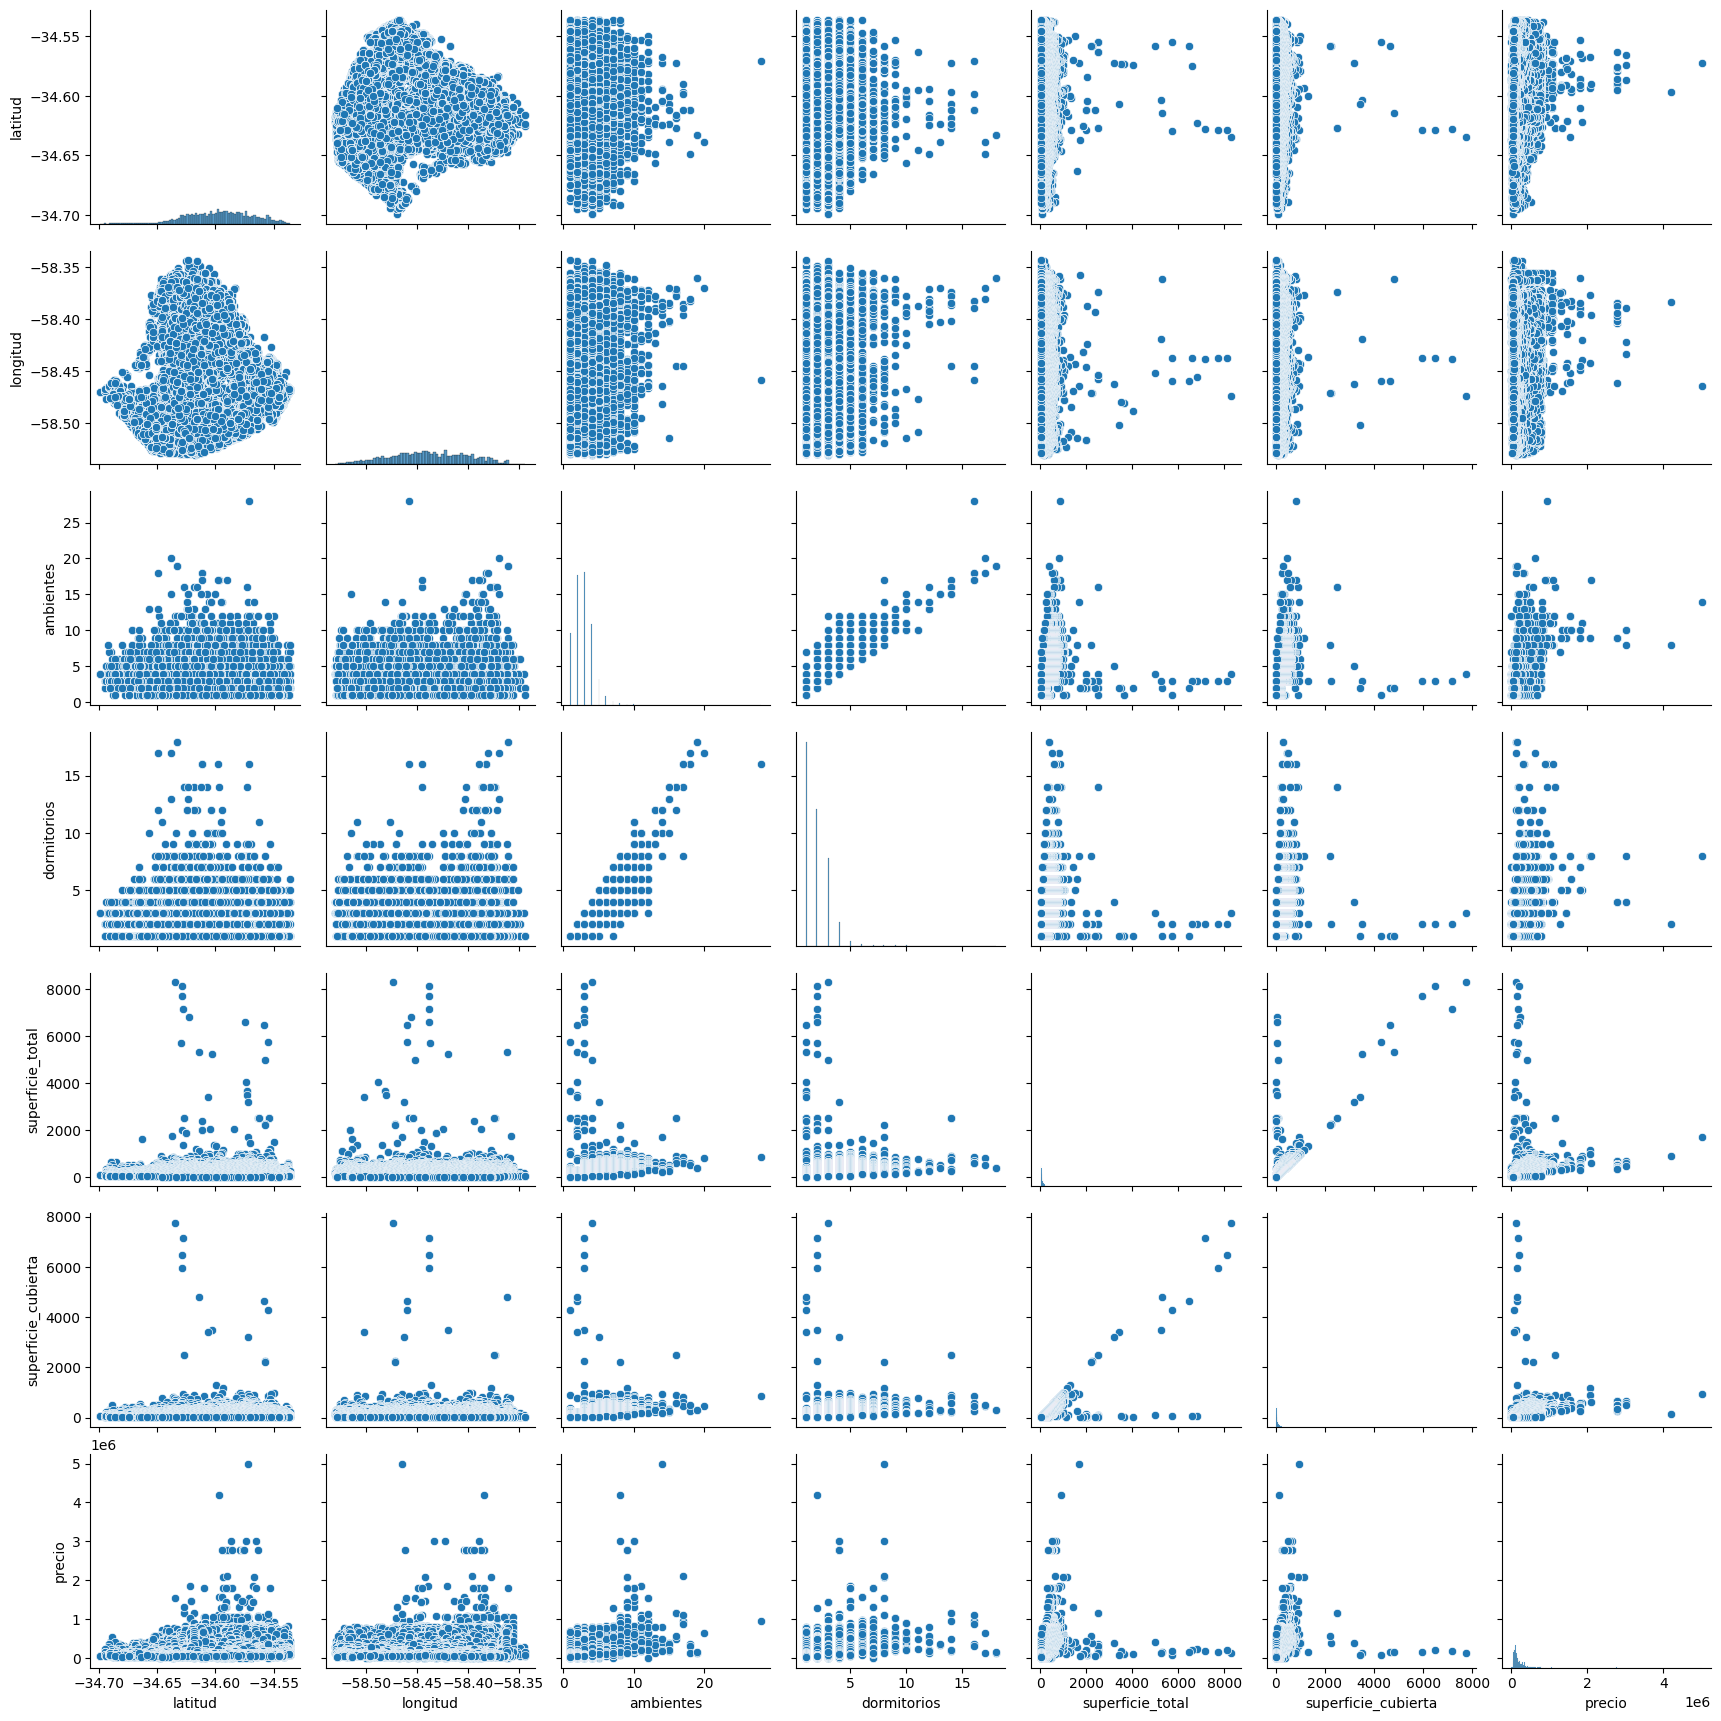

In [4]:
plt.figure(figsize=(10,8));
sns.pairplot(propiedades);

Del gráfico anterior podemos observar que **ambientes, dormitorios, superficie cubierta y superficie total** muestran una posible relación lineal con precio. Por lo tanto, vamos a analizar la correlación de los features con este último.

In [5]:
propiedades_atributos = propiedades[propiedades.columns.difference(['id', 'barrio', 'fecha_inicio', 'fecha_fin', 'nombre', 'tipo'])]
propiedades_atributos.corr().style.background_gradient(cmap='coolwarm')

,ambientes,dormitorios,latitud,longitud,precio,superficie_cubierta,superficie_total
ambientes,1.000000,0.928469,-0.028850,0.012249,0.653450,0.560002,0.479715
dormitorios,0.928469,1.000000,-0.029589,0.009309,0.597936,0.538679,0.461726
latitud,-0.028850,-0.029589,1.000000,-0.140601,0.202522,0.022565,0.009519
longitud,0.012249,0.009309,-0.140601,1.000000,0.081791,0.032391,-0.008956
precio,0.653450,0.597936,0.202522,0.081791,1.000000,0.527717,0.446776
superficie_cubierta,0.560002,0.538679,0.022565,0.032391,0.527717,1.000000,0.835518
superficie_total,0.479715,0.461726,0.009519,-0.008956,0.446776,0.835518,1.000000


Por un lado, seleccionamos *ambientes, dormitorios, superficie_cubierta y superficie_total* como **variables regresoras**.Y por el otro, a *precio* como la variable **a predecir**.
Por este motivo eleminamos de nuestro dataframe a longitud y latitud.

In [6]:
propiedades_atributos = propiedades_atributos[propiedades_atributos.columns.difference(['longitud', 'latitud'])]

In [7]:
def propiedades_boxplot():
  sns.set_context('talk')
  sns.set_style("darkgrid")

  variables=[]
  valores=[]

  variables = ['ambientes']*len(list(propiedades_atributos.ambientes)) + ['dormitorios']*len(list(propiedades_atributos.dormitorios))

  valores = list(propiedades_atributos.ambientes) + list(propiedades_atributos.dormitorios)

  plt.figure(figsize=(12,10))
  grafico=sns.boxplot(x=variables,y=valores)
  grafico.set(xlabel='Variable')

  variables = ['superficie_cubierta']*len(list(propiedades_atributos.superficie_cubierta)) + ['superficie_total']*len(list(propiedades_atributos.superficie_total))

  valores = list(propiedades_atributos.superficie_cubierta) + list(propiedades_atributos.superficie_total)

  plt.figure(figsize=(11.62,10))
  grafico=sns.boxplot(x=variables,y=valores)
  grafico.set(xlabel='Variable')

Graficamos un boxplot para ver la cantidad de outliers de cada feature

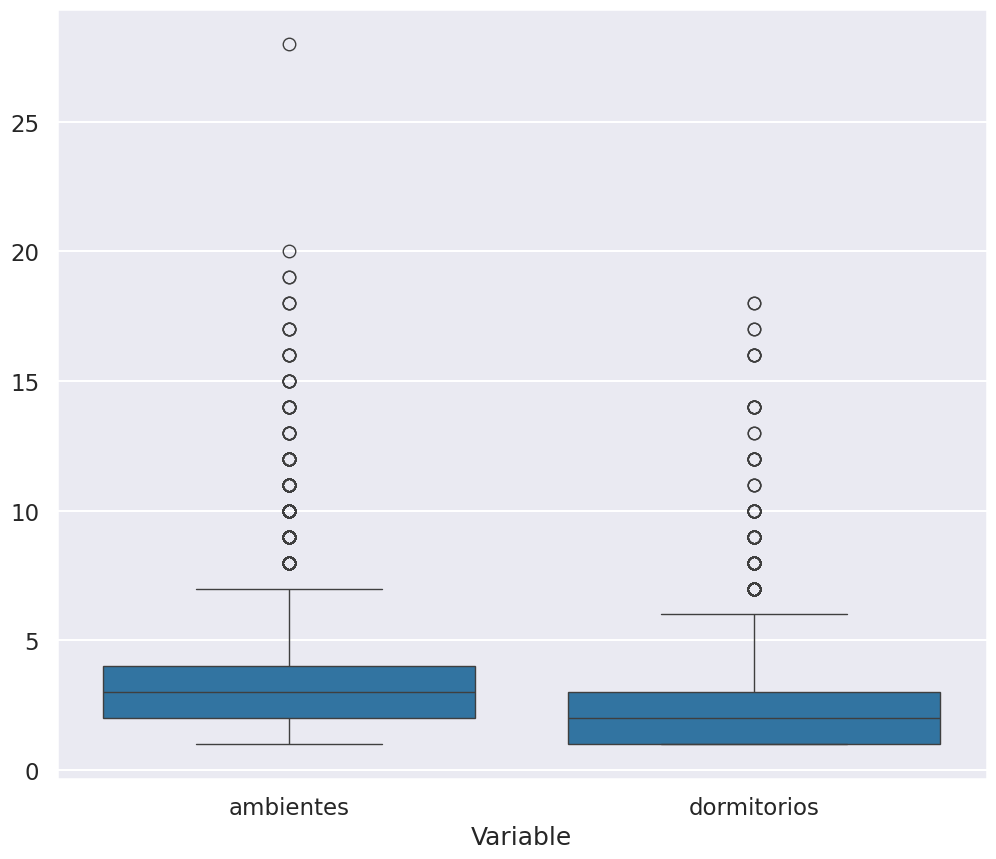

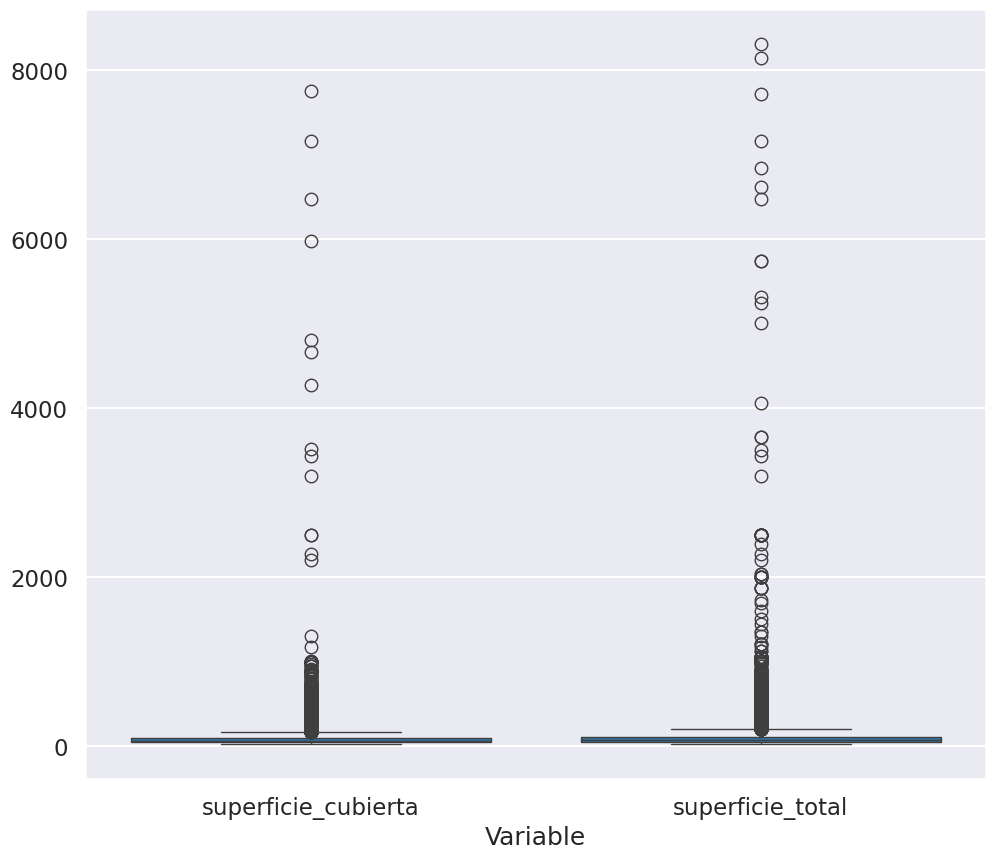

In [8]:
propiedades_boxplot()

Sabemos que las regresiones son suceptibles a los outliers. Por este motivo procederemos a eliminarlos con la regla del 1.5*IQR, dejando solo las observaciones que esten entre 1.5 veces el rango entre cuartiles.

In [9]:
propiedades_atributos.describe().T

,count,mean,std,min,25%,50%,75%,max
ambientes,74011.0,2.839686,1.406803,1.0,2.0,3.0,4.0,28.0
dormitorios,74011.0,1.912027,1.054239,1.0,1.0,2.0,3.0,18.0
precio,74011.0,192933.010552,157992.811693,5000.0,95000.0,144000.0,230000.0,5000000.0
superficie_cubierta,74011.0,79.173880,93.086275,20.0,40.0,57.0,88.0,7755.0
superficie_total,74011.0,94.682426,128.352295,20.0,46.0,67.0,106.0,8306.0


In [10]:
#Calculo los cuantiles de las variables ambientes, dormitorios, superficie_cubierta, superficie_total
ambientes_q3, ambientes_q1 = np.percentile(propiedades_atributos.ambientes, [75 ,25])
dormitorios_q3, dormitorios_q1 = np.percentile(propiedades_atributos.dormitorios, [75 ,25])
superficie_cubierta_q3, superficie_cubierta_q1 = np.percentile(propiedades_atributos.superficie_cubierta, [75 ,25])
superficie_total_q3, superficie_total_q1 = np.percentile(propiedades_atributos.superficie_total, [75 ,25])

#Calculo el rango intercuartil de las variables de ambientes, dormitorios, superficie_cubierta, superficie_total
iqr_ambientes = ambientes_q3 - ambientes_q1
iqr_dormitorios = dormitorios_q3 - dormitorios_q1
iqr_superficie_cubierta = superficie_cubierta_q3 - superficie_cubierta_q1
iqr_superficie_total = superficie_total_q3 - superficie_total_q1

# Elimino outliers de la variable 'ambientes'
propiedades_atributos = propiedades_atributos.query(' ambientes >= (@ambientes_q1 - @iqr_ambientes*1.5) & ambientes <= (@ambientes_q3 + @iqr_ambientes*1.5) ')

# Elimino outliers de la variable 'dormitorios'
propiedades_atributos = propiedades_atributos.query(' dormitorios >= (@dormitorios_q1 - @iqr_dormitorios*1.5) & dormitorios <= (@dormitorios_q3 + @iqr_dormitorios*1.5) ')

# Elimino outliers de la variable 'superficie_cubierta'
propiedades_atributos = propiedades_atributos.query(' superficie_cubierta >= (@superficie_cubierta_q1 - @iqr_superficie_cubierta*1.5) & superficie_cubierta <= (@superficie_cubierta_q3 + @iqr_superficie_cubierta*1.5) ')

# Elimino outliers de la variable 'superficie_total'
propiedades_atributos = propiedades_atributos.query(' superficie_total >= (@superficie_total_q1 - @iqr_superficie_total*1.5) & superficie_total <= (@superficie_total_q3 + @iqr_superficie_total*1.5) ')

Ahora que tenemos el conjunto filtrado graficamos nuevamente para ver los resultados.

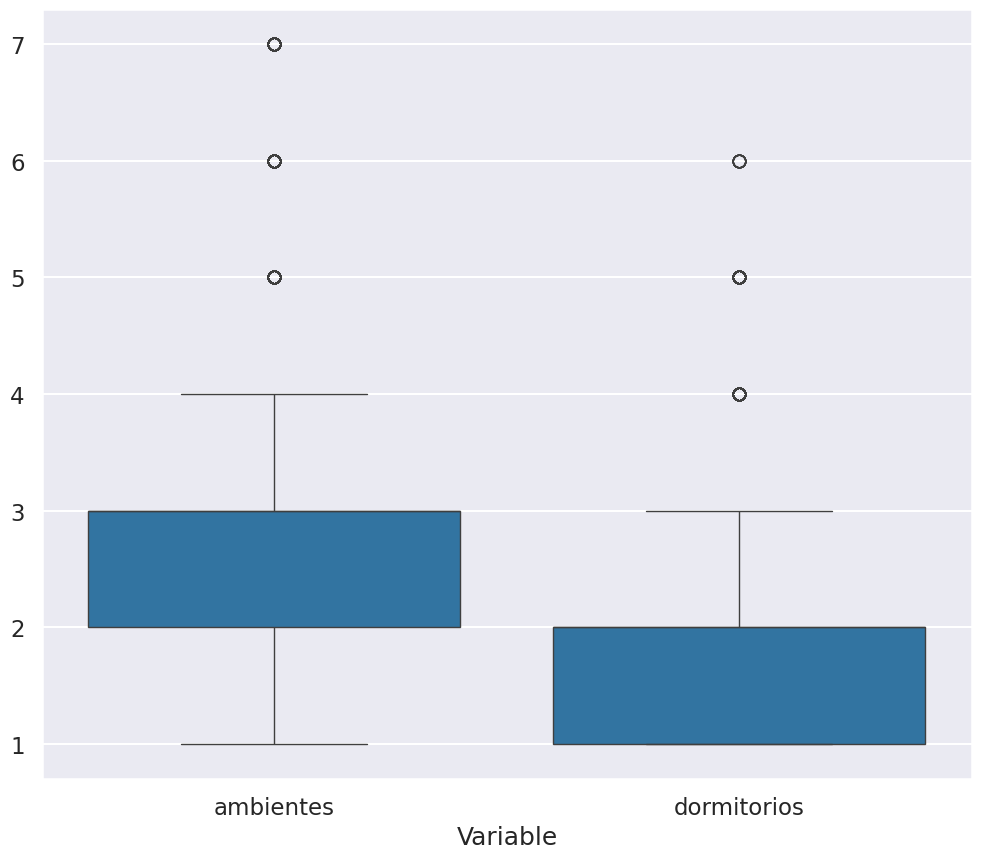

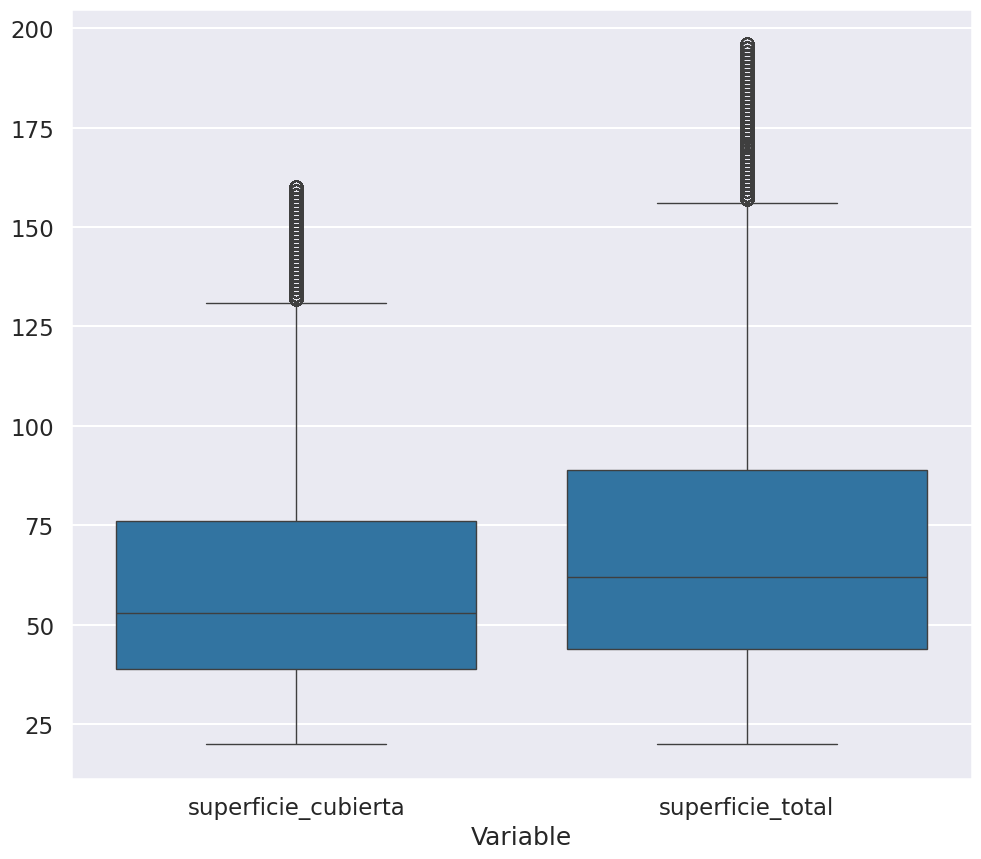

In [11]:
propiedades_boxplot()

Observamos nuevamente la correlación de los atributos luego de la eliminación de outliers.

In [12]:
propiedades_atributos.corr().style.background_gradient(cmap='coolwarm')

,ambientes,dormitorios,precio,superficie_cubierta,superficie_total
ambientes,1.000000,0.919818,0.560133,0.803747,0.766176
dormitorios,0.919818,1.000000,0.549865,0.793071,0.751251
precio,0.560133,0.549865,1.000000,0.752403,0.716118
superficie_cubierta,0.803747,0.793071,0.752403,1.000000,0.924340
superficie_total,0.766176,0.751251,0.716118,0.924340,1.000000


Graficamos un nuevo pairplot para validar los features finales.

<Figure size 1000x800 with 0 Axes>

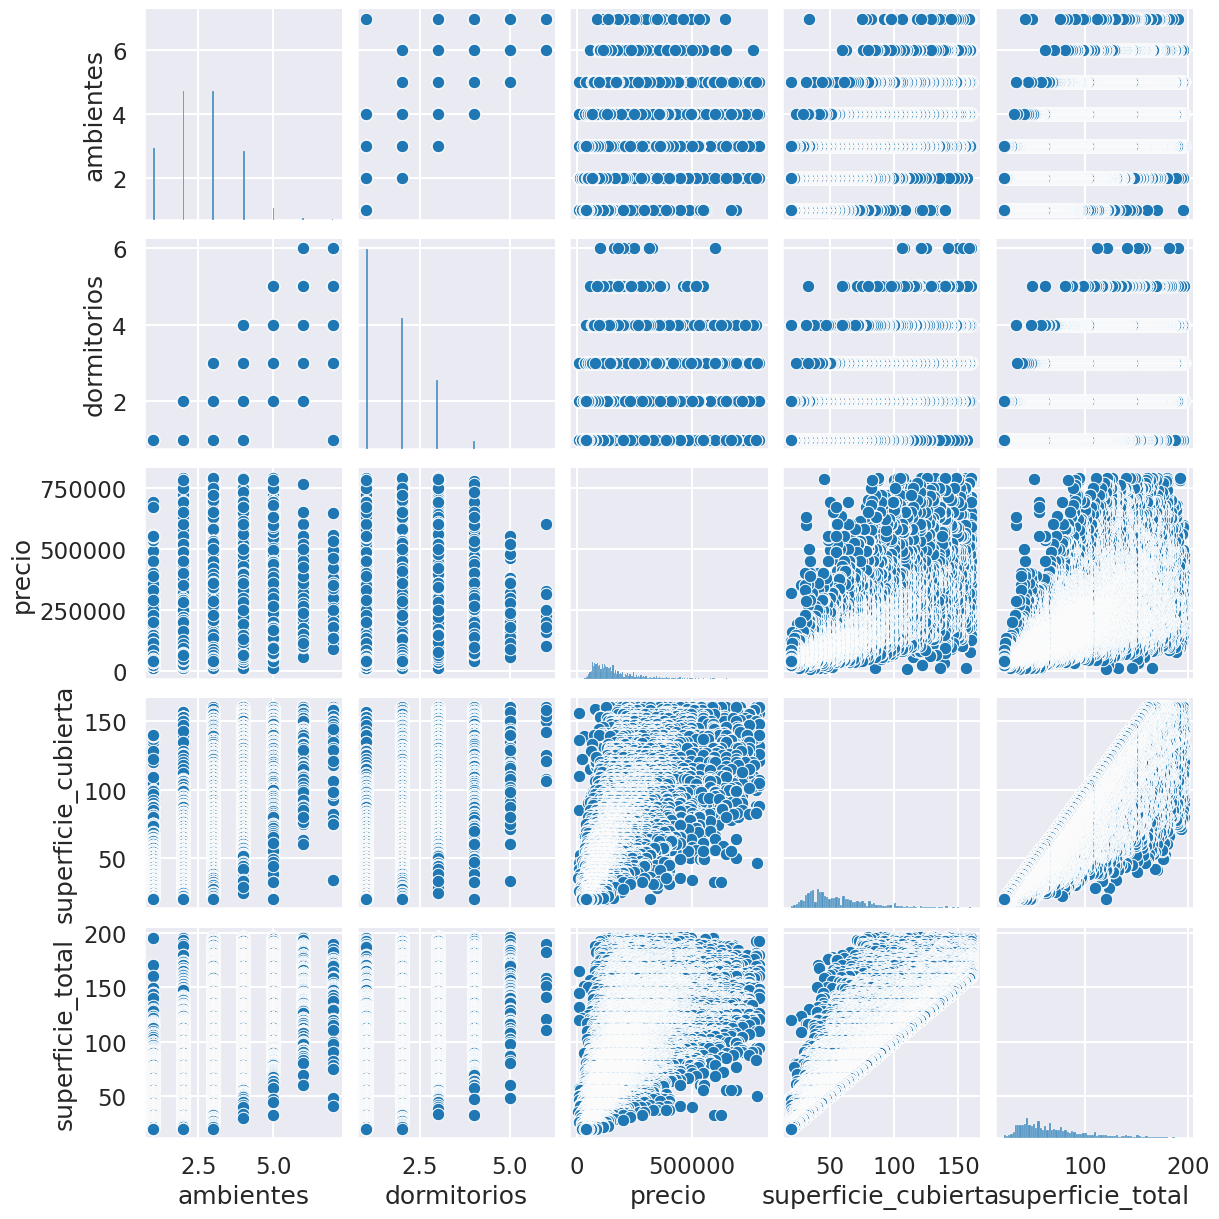

In [13]:
#Grafico de a pares incluyendo variable a predecir
plt.figure(figsize=(10,8));
sns.pairplot(propiedades_atributos);

####Escalamiento de los datos

Normalizaremos los datos con el objetivo de comparar los resultados al entrenar los modelos tanto con los datos escalados como sin escalar.


  Veamos en que estado se encuentra nuestro conjunto de datos de interés.

In [14]:
propiedades_atributos

,ambientes,dormitorios,precio,superficie_cubierta,superficie_total
0,5.0,3.0,390000.0,135.0,137.0
1,4.0,3.0,165000.0,123.0,123.0
2,4.0,3.0,420000.0,100.0,112.0
3,4.0,3.0,210000.0,90.0,98.0
4,2.0,1.0,225000.0,42.0,48.0
...,...,...,...,...,...
74006,1.0,1.0,49000.0,20.0,20.0
74007,1.0,1.0,47000.0,20.0,20.0
74008,1.0,1.0,35400.0,20.0,20.0
74009,1.0,1.0,45000.0,20.0,20.0


Filtramos la columna del precio.

In [15]:
propiedades_precio = propiedades_atributos[propiedades_atributos.columns.difference(['ambientes', 'dormitorios', 'superficie_total', 'superficie_cubierta'])]
propiedades_precio

,precio
0,390000.0
1,165000.0
2,420000.0
3,210000.0
4,225000.0
...,...
74006,49000.0
74007,47000.0
74008,35400.0
74009,45000.0


Creamos dos escaladores: Uno para el conjunto de datos total, y otro que normalizará únicamente los precios, de manera que luego podamos revertir los precios (en usd) a partir de los valores escalados.  
Probamos escalar los datos con: MinMaxScaler, StandardScaler, RobustScaler y PowerTransformer. Entre todas estas opciones hemos obtenido mejores resultados con la última normalización. Por lo tanto optamos por realizar la comparación mencionada con PowerTransformer.

In [16]:
# Escalamos el conjunto con PowerTransformer
scaler_power = PowerTransformer()
escalado_power = scaler_power.fit_transform(propiedades_atributos)
scaler_power_precio = PowerTransformer()
escalado_power_precio = scaler_power_precio.fit_transform(propiedades_precio)

In [17]:
propiedades_escalado_power = pd.DataFrame(escalado_power)
propiedades_escalado_power.rename(columns={0:'ambientes', 1:'dormitorios', 2:'precio', 3:'superficie_cubierta', 4:'superficie_total'}, inplace=True)
propiedades_escalado_power

,ambientes,dormitorios,precio,superficie_cubierta,superficie_total
0,2.001997,1.383871,1.723754,1.834831,1.546976
1,1.272893,1.383871,0.352057,1.669763,1.346916
2,1.272893,1.383871,1.831428,1.286594,1.169884
3,1.272893,1.383871,0.760305,1.082769,0.912407
4,-0.473237,-0.980865,0.873581,-0.583573,-0.569822
...,...,...,...,...,...
66794,-1.595667,-0.980865,-2.024833,-2.562385,-2.637080
66795,-1.595667,-0.980865,-2.116918,-2.562385,-2.637080
66796,-1.595667,-0.980865,-2.763654,-2.562385,-2.637080
66797,-1.595667,-0.980865,-2.213816,-2.562385,-2.637080


####Split train/test

Separamos el dataframe en 80/20 (sin escalar)

In [18]:
X = propiedades_atributos[['ambientes', 'dormitorios', 'superficie_cubierta', 'superficie_total']]
y = propiedades_atributos.precio.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

Separamos el dataframe en 80/20 (escalado)

In [19]:
escalador_precio = scaler_power_precio
X_escalado = propiedades_escalado_power[['ambientes', 'dormitorios', 'superficie_cubierta', 'superficie_total']]
y_escalado = propiedades_escalado_power.precio.copy()

X_train_escalado, X_test_escalado, y_train_escalado, y_test_escalado = train_test_split(X_escalado, y_escalado, test_size= 0.2, random_state=0)

## KNN

### KNN Sin Escalado

#### KNN Basico

Creamos y entrenamos el modelo sin elegir hiperparametros, es decir, un KNN totalmente por default.

In [ ]:
knn_regressor = KNeighborsRegressor().fit(X_train, y_train)
knn_regressor.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Realizamos la prediccion con el modelo y visualizamos la performance

In [ ]:
y_pred = knn_regressor.predict(X_test)
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred,
                            'Error': y_test - y_pred})
performance.head()

,Valor Real,Prediccion,Error
27124,248000.0,202980.0,45020.0
40225,130000.0,156432.8,-26432.8
37956,98226.0,146868.2,-48642.2
67814,69000.0,70997.8,-1997.8
10745,224500.0,293774.0,-69274.0


Visualizemos sus Métricas: el error cuadrático medio (MSE), tambien su raíz (RMSE) y el error absoluto medio (MAE)

In [ ]:
mse = metrics.mean_squared_error(y_true = y_test,
                                 y_pred  = y_pred,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test,
                                  y_pred  = y_pred,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test,
                                  y_pred  = y_pred)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 4494715955.1897955
El error (RMSE) de test es: 67042.64281179401
El error (MAE) de test es: 42555.04200598803


Veamos también su Coeficiente de Determinacion (R2 score)

In [ ]:
#Coef. de Determinación R2
r2 = r2_score(y_test, y_pred)
print(f"El valor del R2 Score es: {r2}")

El valor del R2 Score es: 0.6061889876681305


#### Cross Validation

Buscaremos los mejores hiperparametros (seleccionando MSE, como la metrica a mejorar), con **Grid Search Cross Validation** de X Folds.

In [ ]:
param_grid = {
    'n_neighbors': [21, 22, 23, 24, 25],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de peso
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métrica de distancia
}

knn_cv = KNeighborsRegressor()
scorer_fn = make_scorer(mean_squared_error) #r2_score - mean_squared_error - mean_absolute_error

# Inicializa el GridSearchCV con el modelo, los hiperparámetros y la métrica de evaluación
grid_search = GridSearchCV(estimator=knn_cv, param_grid=param_grid, cv=50, scoring=scorer_fn)

# Ajusta el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

GridSearchCV(cv=50, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [21, 22, 23, 24, 25],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(mean_squared_error))

Obtenemos la mejor combinacion de hiperparametros y vemos cual fue la mejor metrica:

In [ ]:
print("Mejores hiperparámetros:", grid_search.best_params_)
param_seleccionados = grid_search.best_params_

print("Mejor puntuación de la métrica seleccionada:", grid_search.best_score_)

# Evalúa el modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Coef. de Determinación R2:", test_score)

Mejores hiperparámetros: {'metric': 'euclidean', 'n_neighbors': 25, 'weights': 'uniform'}
Mejor puntuación de la métrica seleccionada: 4558034264.19279
Coef. de Determinación R2: 0.614754985667714


#### KNN Final

Creamos y entrenamos el modelo elegiendo los mejores hiperparametros propuestos segun el **Grid Search Cross Validation**.

In [ ]:
best_knn = KNeighborsRegressor(n_neighbors = param_seleccionados['n_neighbors'],
                               weights = param_seleccionados['weights'],
                               metric = param_seleccionados['metric']).fit(X_train, y_train)

Realizamos la prediccion con el modelo y visualizamos la performance

In [ ]:
y_pred = best_knn.predict(X_test)
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred,
                            'Error': y_test - y_pred})
performance.head()

,Valor Real,Prediccion,Error
27124,248000.0,230336.00,17664.00
40225,130000.0,158165.40,-28165.40
37956,98226.0,156797.84,-58571.84
67814,69000.0,78801.96,-9801.96
10745,224500.0,345447.16,-120947.16


Visualizemos sus Métricas: el error cuadrático medio (MSE), tambien su raíz (RMSE) y el error absoluto medio (MAE)

In [ ]:
mse = metrics.mean_squared_error(y_true = y_test,
                                 y_pred  = y_pred,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test,
                                  y_pred  = y_pred,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test,
                                  y_pred  = y_pred)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 4396948938.333481
El error (RMSE) de test es: 66309.49357621034
El error (MAE) de test es: 42069.509586826345


Veamos también su Coeficiente de Determinacion (R2 score)

In [ ]:
#Coef. de Determinación R2
r2 = r2_score(y_test, y_pred)
print(f"El valor del R2 Score es: {r2}")

El valor del R2 Score es: 0.614754985667714


### KNN Escalado

#### KNN Escalado Basico

Creamos y entrenamos el modelo sin elegir hiperparametros, es decir, un KNN totalmente por default pero con los datos escalados.

In [20]:
knn_regressor_escalado = KNeighborsRegressor().fit(X_train_escalado, y_train_escalado)
knn_regressor_escalado.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Realizamos la prediccion con el modelo y visualizamos la performance

In [21]:
y_pred_escalado = knn_regressor_escalado.predict(X_test_escalado)
performance_escalado = pd.DataFrame({'Valor Real': y_test_escalado,
                            'Prediccion': y_pred_escalado,
                            'Error': y_test_escalado - y_pred_escalado})
performance_escalado.head()

,Valor Real,Prediccion,Error
19913,1.030789,1.038467,-0.007679
33013,-0.071018,0.476885,-0.547904
30744,-0.594403,0.252763,-0.847167
60602,-1.296361,-1.189606,-0.106755
3547,0.869952,1.064986,-0.195034


Visualizemos sus Métricas: el error cuadrático medio (MSE), tambien su raíz (RMSE) y el error absoluto medio (MAE)

In [22]:
mse = metrics.mean_squared_error(y_true = y_test_escalado,
                                 y_pred  = y_pred_escalado,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test_escalado,
                                  y_pred  = y_pred_escalado,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test_escalado,
                                  y_pred  = y_pred_escalado)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 0.352417112651207
El error (RMSE) de test es: 0.5936472965079577
El error (MAE) de test es: 0.4513201100403225


Veamos también su Coeficiente de Determinacion (R2 score)

In [23]:
#Coef. de Determinación R2
r2 = r2_score(y_test_escalado, y_pred_escalado)
print(f"El valor del R2 Score es: {r2}")

El valor del R2 Score es: 0.6454397518372047


Veamos las metricas en la escala original (usd).  

In [24]:
y_test_usd = np.array(performance_escalado['Valor Real']).reshape(-1, 1)
y_test_usd = escalador_precio.inverse_transform(y_test_usd)

y_pred_usd = np.array(performance_escalado['Prediccion']).reshape(-1, 1)
y_pred_usd = escalador_precio.inverse_transform(y_pred_usd)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [25]:
mse = metrics.mean_squared_error(y_true = y_test_usd,
                                 y_pred  = y_pred_usd,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test_usd,
                                  y_pred  = y_pred_usd,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test_usd,
                                  y_pred  = y_pred_usd)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 4623811755.56732
El error (RMSE) de test es: 67998.61583567213
El error (MAE) de test es: 42435.53048771619


#### Cross Validation

Buscaremos los mejores hiperparametros (seleccionando MSE, como la metrica a mejorar), con **Grid Search Cross Validation** de X Folds.

In [26]:
X_train_escalado

,ambientes,dormitorios,superficie_cubierta,superficie_total
17830,0.459634,0.649570,0.945980,0.677664
16852,0.459634,0.649570,0.046197,0.722856
22808,0.459634,0.649570,0.687673,0.431789
58355,-1.595667,-0.980865,-1.035752,-1.155837
49334,-0.473237,-0.980865,-0.526786,-0.712840
...,...,...,...,...
41993,-0.473237,-0.980865,-0.315321,-0.394540
21243,0.459634,0.649570,0.742783,0.509316
45891,-0.473237,-0.980865,-0.583573,-0.569822
42613,-0.473237,-0.980865,-0.418074,-0.436850


In [27]:
param_grid = {
    'n_neighbors': [21, 22, 23, 24, 25],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Tipo de peso
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métrica de distancia
}

knn_cv_escalado = KNeighborsRegressor()
scorer_fn = make_scorer(mean_squared_error) #r2_score - mean_squared_error - mean_absolute_error

# Inicializa el GridSearchCV con el modelo, los hiperparámetros y la métrica de evaluación
grid_search_escalado = GridSearchCV(estimator=knn_cv_escalado,
                                            param_grid=param_grid,
                                            cv=50,
                                            scoring=scorer_fn)

# Ajusta el modelo a los datos de entrenamiento
grid_search_escalado.fit(X_train_escalado, y_train_escalado)

GridSearchCV(cv=50, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [21, 22, 23, 24, 25],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(mean_squared_error))

Obtenemos la mejor combinacion de hiperparametros y vemos cual fue la mejor metrica:

In [28]:
print("Mejores hiperparámetros:", grid_search_escalado.best_params_)
param_seleccionados_escalado = grid_search_escalado.best_params_

print("Mejor puntuación de la métrica seleccionada:", grid_search_escalado.best_score_)

# Evalúa el modelo en el conjunto de prueba
best_model_escalado = grid_search_escalado.best_estimator_
test_score_escalado = best_model_escalado.score(X_test_escalado, y_test_escalado)
print("Coef. de Determinación R2:", test_score_escalado)

Mejores hiperparámetros: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'distance'}
Mejor puntuación de la métrica seleccionada: 0.3354753512378253
Coef. de Determinación R2: 0.676177733790286


Probamos el modelo con los mejores hiperparametros del POWER

In [29]:
best_knn_escalado = KNeighborsRegressor(n_neighbors = param_seleccionados_escalado['n_neighbors'],
                               weights = param_seleccionados_escalado['weights'],
                               metric = param_seleccionados_escalado['metric']).fit(X_train_escalado, y_train_escalado)

Realizamos la prediccion con el modelo y visualizamos la performance

In [30]:
y_pred_escalado = best_knn_escalado.predict(X_test_escalado)
performance_escalado = pd.DataFrame({'Valor Real': y_test_escalado,
                            'Prediccion': y_pred_escalado,
                            'Error': y_test_escalado - y_pred_escalado})
performance_escalado.head()

,Valor Real,Prediccion,Error
19913,1.030789,0.709437,0.321352
33013,-0.071018,0.493441,-0.564460
30744,-0.594403,0.071711,-0.666114
60602,-1.296361,-1.115529,-0.180832
3547,0.869952,1.037224,-0.167272


Visualizemos sus Métricas: el error cuadrático medio (MSE), tambien su raíz (RMSE) y el error absoluto medio (MAE)

In [31]:
mse = metrics.mean_squared_error(y_true = y_test_escalado,
                                 y_pred  = y_pred_escalado,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test_escalado,
                                  y_pred  = y_pred_escalado,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test_escalado,
                                  y_pred  = y_pred_escalado)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 0.3218649260912064
El error (RMSE) de test es: 0.5673314076368472
El error (MAE) de test es: 0.42080311586095387


Veamos también su Coeficiente de Determinacion (R2 score)

In [32]:
#Coef. de Determinación R2
score_knn_escalado = best_knn_escalado.score(X_test_escalado, y_test_escalado)
score_knn_escalado

0.676177733790286

Veamos las metricas en la escala original (usd).  

In [33]:
y_test_usd = np.array(performance_escalado['Valor Real']).reshape(-1, 1)
y_test_usd = escalador_precio.inverse_transform(y_test_usd)

y_pred_usd = np.array(performance_escalado['Prediccion']).reshape(-1, 1)
y_pred_usd = escalador_precio.inverse_transform(y_pred_usd)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [34]:
mse = metrics.mean_squared_error(y_true = y_test_usd,
                                 y_pred  = y_pred_usd,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test_usd,
                                  y_pred  = y_pred_usd,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test_usd,
                                  y_pred  = y_pred_usd)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 4339234121.927372
El error (RMSE) de test es: 65872.86331963543
El error (MAE) de test es: 39499.16280649889


#### KNN Escalado Final

Creamos y entrenamos el modelo elegiendo los mejores hiperparametros propuestos segun el **Grid Search Cross Validation**, pero esta vez, con los datos escalados.

In [35]:
best_knn_escalado = KNeighborsRegressor(n_neighbors = param_seleccionados_escalado['n_neighbors'],
                               weights = param_seleccionados_escalado['weights'],
                               metric = param_seleccionados_escalado['metric']).fit(X_train_escalado, y_train_escalado)

Realizamos la prediccion con el modelo y visualizamos la performance

In [36]:
y_pred_escalado = best_knn_escalado.predict(X_test_escalado)
performance_escalado = pd.DataFrame({'Valor Real': y_test_escalado,
                            'Prediccion': y_pred_escalado,
                            'Error': y_test_escalado - y_pred_escalado})
performance_escalado.head()

,Valor Real,Prediccion,Error
19913,1.030789,0.709437,0.321352
33013,-0.071018,0.493441,-0.564460
30744,-0.594403,0.071711,-0.666114
60602,-1.296361,-1.115529,-0.180832
3547,0.869952,1.037224,-0.167272


Visualizemos sus Métricas: el error cuadrático medio (MSE), tambien su raíz (RMSE) y el error absoluto medio (MAE)

In [37]:
mse = metrics.mean_squared_error(y_true = y_test_escalado,
                                 y_pred  = y_pred_escalado,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test_escalado,
                                  y_pred  = y_pred_escalado,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test_escalado,
                                  y_pred  = y_pred_escalado)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 0.3218649260912064
El error (RMSE) de test es: 0.5673314076368472
El error (MAE) de test es: 0.42080311586095387


Veamos también su Coeficiente de Determinacion (R2 score)

In [38]:
#Coef. de Determinación R2
r2 = r2_score(y_test_escalado, y_pred_escalado)
print(f"El valor del R2 Score es: {r2}")

El valor del R2 Score es: 0.676177733790286


Para finalizar, guardamos el mejor KNN en un archivo joblib

In [39]:
joblib.dump(best_knn_escalado, 'best_knn_regressor.pkl')

['best_knn_regressor.pkl']

## XGBoost

###XGBoost (100% Default)

Creamos y entrenamos el modelo sin elegir hiperparametros, es decir, un XGBoost totalmente por default (salvo por el `random_state` para eliminarle la aleatoriedad entre ejecuciones).

In [40]:
xgbr = xgb.XGBRegressor(random_state=10).fit(X_train, y_train)

In [41]:
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 10,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

Realizamos la prediccion con el modelo y visualizamos la performance

In [42]:
y_pred = xgbr.predict(X_test)
performance_xgb = pd.DataFrame({'Valor Real': y_test,
                                'Prediccion': y_pred,
                                'Error': y_test - y_pred})
performance_xgb.head()

,Valor Real,Prediccion,Error
27124,248000.0,216395.046875,31604.953125
40225,130000.0,170976.609375,-40976.609375
37956,98226.0,176854.484375,-78628.484375
67814,69000.0,86778.054688,-17778.054688
10745,224500.0,304299.031250,-79799.031250


Visualizemos sus Métricas: el error cuadrático medio (MSE), tambien su raíz (RMSE) y el error absoluto medio (MAE)

In [43]:
mse = metrics.mean_squared_error(y_true = y_test,
                                 y_pred  = y_pred,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test,
                                  y_pred  = y_pred,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test,
                                  y_pred  = y_pred)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 4132423645.638654
El error (RMSE) de test es: 64283.92991750469
El error (MAE) de test es: 40841.82599059693


Veamos también su Coeficiente de Determinacion (R2 score)

In [44]:
#Coef. de Determinación R2
r2 = r2_score(y_test, y_pred)
print(f"El valor del R2 Score es: {r2}")

El valor del R2 Score es: 0.6379317501934569


###Cross Validation

**Hiper-parámetros**

* learning_rate: tasa de aprendizaje
+ max_depth: máxima profundidad de cada árbol
* subsample: porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* colsample_bytree: porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* n_estimators: cantidad de árboles a construir.
* objective: función de error a utilizar (algunas: reg:linear para regresión,
* reg:logistic o binary:logistic para clasificación)

**Parámetros de regularización:**

* **gamma**: umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha**: regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda**: similar alpha pero para la sintonia fina.

Buscaremos los mejores hiperparametros (seleccionando MSE, como la metrica a mejorar), con **Grid Search Cross Validation** de X Folds.

In [45]:
param_grid2 = {
    'n_estimators': [70, 100],
    'learning_rate': [0.3, 0.4],
    'alpha': [1, 2]

    }

xgbr_cv = xgb.XGBRegressor(random_state=10)
scorer_fn2 = make_scorer(mean_squared_error) # r2_score - mean_squared_error - mean_absolute_error

# Inicializa el GridSearchCV con el modelo, los hiperparámetros y la métrica de evaluación
grid_search = GridSearchCV(estimator=xgbr_cv, param_grid=param_grid2, cv=10, scoring=scorer_fn2)

# Ajusta el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None,...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=10, ...),
             param_grid={'alpha': [1, 2], 'learning_rate': [0.3, 0.4],
                         'n_estimators': [70, 100]},
             scoring=make_scorer(mean_squared_error))

Obtenemos la mejor combinacion de hiperparametros y vemos cual fue la mejor metrica:

In [46]:
print("Mejores hiperparámetros:", grid_search.best_params_)
param_selecciona2 = grid_search.best_params_

print("Mejor puntuación de la métrica seleccionada:", grid_search.best_score_)

# Evalúa el modelo en el conjunto de prueba
best_model_xgbr = grid_search.best_estimator_
test_score = best_model_xgbr.score(X_test, y_test)
print("Coef. de Determinación R2:", test_score)

Mejores hiperparámetros: {'alpha': 1, 'learning_rate': 0.4, 'n_estimators': 100}
Mejor puntuación de la métrica seleccionada: 4375233814.2719
Coef. de Determinación R2: 0.6368003102345743


###XGBoost (con Optimizaciones)

Creamos y entrenamos el modelo elegiendo los mejores hiperparametros propuestos segun el **Grid Search Cross Validation**.

In [47]:
best_xgbr = xgb.XGBRegressor(n_estimators = param_selecciona2['n_estimators'],
                            alpha = param_selecciona2['alpha'],
                            learning_rate = param_selecciona2['learning_rate'],
                            random_state=10).fit(X_train, y_train)

Realizamos la prediccion con el modelo y visualizamos la performance

In [48]:
y_pred = best_xgbr.predict(X_test)
performance_xgbr = pd.DataFrame({'Valor Real': y_test,
                                 'Prediccion': y_pred,
                                 'Error': y_test - y_pred})
performance_xgbr.head()

,Valor Real,Prediccion,Error
27124,248000.0,211017.468750,36982.531250
40225,130000.0,177709.656250,-47709.656250
37956,98226.0,182204.750000,-83978.750000
67814,69000.0,86053.640625,-17053.640625
10745,224500.0,294804.531250,-70304.531250


Visualizemos sus Métricas: el error cuadrático medio (MSE), tambien su raíz (RMSE) y el error absoluto medio (MAE)

In [49]:
mse = metrics.mean_squared_error(y_true = y_test,
                                 y_pred  = y_pred,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test,
                                  y_pred  = y_pred,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test,
                                  y_pred  = y_pred)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 4145337203.3510633
El error (RMSE) de test es: 64384.29314165888
El error (MAE) de test es: 40815.54001099364


Veamos también su Coeficiente de Determinacion (R2 score)

In [50]:
#Coef. de Determinación R2
r2 = r2_score(y_test, y_pred)
print(f"El valor del R2 Score es: {r2}")

El valor del R2 Score es: 0.6368003102345743


Concluyendo, el mejor XGBoost en nuestro caso fue el 100% default. Y procederemos a guardarlo en un archivo joblib.

In [51]:
joblib.dump(xgbr, 'best_xgboost_regressor.pkl')

['best_xgboost_regressor.pkl']

##Modelo a Eleccion

Luego de debatir un rato, nuestras opciones a elegir fueron AdaBoost y Gradient Boosting. Nos terminamos de decantar por AdaBoost, ya que tarda menos en entrenarse y suele trabajar mejor con datasets que tengan mucho ruido. Todo esto, a costa de resignar una mejor performance a comparación del Gradient Boosting.

###AdaBoost (100% Default)

Creamos y entrenamos el modelo sin elegir hiperparametros, es decir, un AdaBoost totalmente por default (salvo por el `random_state` para eliminarle la aleatoriedad entre ejecuciones).

In [52]:
ada_boost = AdaBoostRegressor(random_state = 10).fit(X_train, y_train)

In [53]:
ada_boost.get_params()

{'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': 10}

Realizamos la prediccion con el modelo y visualizamos la performance

In [54]:
y_pred = ada_boost.predict(X_test)
performance_ada_boost = pd.DataFrame({'Valor Real': y_test,
                                'Prediccion': y_pred,
                                'Error': y_test - y_pred})
performance_ada_boost.head()

,Valor Real,Prediccion,Error
27124,248000.0,261313.273576,-13313.273576
40225,130000.0,167096.935287,-37096.935287
37956,98226.0,183786.283356,-85560.283356
67814,69000.0,97718.566079,-28718.566079
10745,224500.0,359863.696820,-135363.696820


Visualizemos sus Métricas: el error cuadrático medio (MSE), tambien su raíz (RMSE) y el error absoluto medio (MAE)

In [55]:
mse = metrics.mean_squared_error(y_true = y_test,
                                 y_pred  = y_pred,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test,
                                  y_pred  = y_pred,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test,
                                  y_pred  = y_pred)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 5541679780.762292
El error (RMSE) de test es: 74442.45952923836
El error (MAE) de test es: 51106.77724216295


Veamos también su Coeficiente de Determinacion (R2 score)

In [56]:
#Coef. de Determinación R2
r2 = r2_score(y_test, y_pred)
print(f"El valor del R2 Score es: {r2}")

El valor del R2 Score es: 0.514457744107014


###Cross Validation

Buscaremos los mejores hiperparametros (seleccionando MSE, como la metrica a mejorar), con **Grid Search Cross Validation** de X Folds.

In [57]:
# Definir los hiperparámetros a buscar
param_grid3 = {
    'n_estimators': [100, 150, 200],  # Número de estimadores (modelos débiles)
    'learning_rate': [0.1, 0.2, 0.3]  # Tasa de aprendizaje
}

ada_boost_cv = AdaBoostRegressor(random_state=10)
# Definir la métrica a utilizar para evaluar los modelos
scorer_fn3 = make_scorer(mean_squared_error) #r2_score - mean_squared_error - mean_absolute_error

# Inicializar el Grid Search Cross Validation
grid_search = GridSearchCV(estimator=ada_boost_cv, param_grid=param_grid3, scoring=scorer_fn3, refit='MSE', cv=20)

# Realizar el Grid Search Cross Validation en los datos de entrenamiento
grid_search.fit(X_train, y_train)

GridSearchCV(cv=20, estimator=AdaBoostRegressor(random_state=10),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'n_estimators': [100, 150, 200]},
             refit='MSE', scoring=make_scorer(mean_squared_error))

Obtenemos la mejor combinacion de hiperparametros y vemos cual fue la mejor metrica:

In [58]:
print("Mejores hiperparámetros:", grid_search.best_params_)
param_seleccionados3 = grid_search.best_params_

print("Mejor puntuación de la métrica seleccionada:", grid_search.best_score_)

# Evalúa el modelo en el conjunto de prueba
best_model_ada_boost = grid_search.best_estimator_
test_score = best_model_ada_boost.score(X_test, y_test)
print("Coef. de Determinación R2:", test_score)

Mejores hiperparámetros: {'learning_rate': 0.3, 'n_estimators': 100}
Mejor puntuación de la métrica seleccionada: 5871762450.56868
Coef. de Determinación R2: 0.5200514062604881


###AdaBoost (con Optimizaciones)

Creamos y entrenamos el modelo elegiendo los mejores hiperparametros propuestos segun el **Grid Search Cross Validation**.

In [59]:
best_ada_boost = AdaBoostRegressor(n_estimators = param_seleccionados3['n_estimators'],
                                   learning_rate = param_seleccionados3['learning_rate'],
                                   random_state=10).fit(X_train, y_train)

Realizamos la prediccion con el modelo y visualizamos la performance

In [60]:
y_pred = best_ada_boost.predict(X_test)
performance_ada_b = pd.DataFrame({'Valor Real': y_test,
                                 'Prediccion': y_pred,
                                 'Error': y_test - y_pred})
performance_ada_b.head()

,Valor Real,Prediccion,Error
27124,248000.0,272053.985201,-24053.985201
40225,130000.0,174006.992752,-44006.992752
37956,98226.0,185757.995279,-87531.995279
67814,69000.0,102970.468753,-33970.468753
10745,224500.0,370135.618842,-145635.618842


Visualizemos sus Métricas: el error cuadrático medio (MSE), tambien su raíz (RMSE) y el error absoluto medio (MAE)

In [61]:
mse = metrics.mean_squared_error(y_true = y_test,
                                 y_pred  = y_pred,
                                 squared = True)

print(f"El error (MSE) de test es: {mse}")

rmse = metrics.mean_squared_error(y_true  = y_test,
                                  y_pred  = y_pred,
                                  squared = False)

print(f"El error (RMSE) de test es: {rmse}")

mae = metrics.mean_absolute_error(y_true  = y_test,
                                  y_pred  = y_pred)

print(f"El error (MAE) de test es: {mae}")

El error (MSE) de test es: 5477837171.637959
El error (RMSE) de test es: 74012.41228090027
El error (MAE) de test es: 51569.409561399385


Veamos también su Coeficiente de Determinacion (R2 score)

In [62]:
#Coef. de Determinación R2
r2 = r2_score(y_test, y_pred)
print(f"El valor del R2 Score es: {r2}")

El valor del R2 Score es: 0.5200514062604881


Concluyendo, este fue el mejor AdaBoost, en nuestro caso. Y procederemos a guardarlo en un archivo joblib.

In [63]:
joblib.dump(best_ada_boost, 'best_adaboost_regressor.pkl')

['best_adaboost_regressor.pkl']